## Здесь формируется таблица для Саньки

## А также идет проверка на вшивость замен с дерева

## *RefNuc* у Саньки это отцовский

In [1]:
from collections import defaultdict
import json
import os
import sys
import time

from scipy.stats import mannwhitneyu
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ete3 import PhyloTree
from rna_tools.SecondaryStructure import parse_vienna_to_pairs
import tqdm

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from src.utils import FastaStorage, node_parent, read_fasta_generator

In [15]:
PATH_TO_MUT = "../data/mutation_dists.filtered.csv"

mut = pd.read_csv(PATH_TO_MUT)
mut.head(2)

,mut_id,pos,parent_nucl,child_nucl,parent_nucl_context,child_nucl_context,parent_node,child_node,topology_dist
0,0,1086,G,A,gtGtt,gtAtt,#54520#,#54519#,0
1,1,3676,T,C,atTtt,atCtt,#54520#,#54519#,0


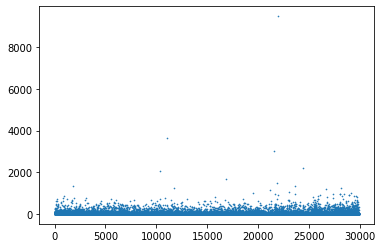

In [3]:
vc = mut.pos.value_counts()

plt.scatter(vc.index, vc.values, s=.4);

In [4]:
most_mut = mut[mut.pos.isin(vc[vc > 1000].index)]
most_mut["mut"] = most_mut.parent_nucl + ">" + most_mut.child_nucl

/tmp/ipykernel_12246/1640980281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_mut["mut"] = most_mut.parent_nucl + ">" + most_mut.child_nucl


In [5]:
most_mut.groupby("pos").mut.value_counts(normalize=True).sort_values(ascending=False).head(30).sort_index()

pos    mut
1819   A>G    0.472686
       G>A    0.517451
10322  A>G    0.505105
       G>A    0.494895
11082  G>T    0.528713
       T>G    0.467697
11749  C>T    0.501199
       T>C    0.488409
16886  C>T    0.502087
       T>C    0.497913
19523  C>T    0.496524
       T>C    0.479643
21136  A>G    0.504274
       G>A    0.492308
21574  C>T    0.501995
       T>C    0.495346
21845  C>T    0.491803
       T>C    0.482923
21986  A>G    0.476115
       G>A    0.512180
23011  A>G    0.397018
       G>A    0.432432
23603  A>C    0.317806
       C>A    0.306536
24409  A>G    0.468921
       G>A    0.484918
26680  C>T    0.507222
       T>C    0.492778
28094  A>T    0.502015
       T>A    0.486704
Name: mut, dtype: float64

In [11]:
vc.head(10)

21986    9483
11082    3622
21574    3008
24409    2188
10322    2057
16886    1677
21845    1464
23603    1331
1819     1318
11749    1251
Name: pos, dtype: int64

In [95]:
mut = pd.read_csv(PATH_TO_MUT)
annot = pd.read_csv("../data/gisaid/metadata_clean.csv")


In [96]:
# only terminal mutations
mut = mut[~mut.child_node.str.startswith("#")]
mut.shape

(558991, 9)

In [97]:

# remove ambiguous records from annot table 
_annot_vc = annot.strain.value_counts()
amb_strains = set(_annot_vc[(_annot_vc > 1)].index)
annot = annot[~annot.strain.isin(amb_strains)]
print(annot.shape)


(4187537, 12)


In [98]:
mut2 = pd.merge(
    mut, 
    annot[["strain", "date"]], 
    left_on="child_node", 
    right_on="strain"
)
mut2.drop("strain", axis=1, inplace=True)

In [99]:
mut2.shape, mut.shape

((557634, 10), (558991, 9))

In [114]:
mut2 = mut2[mut2.date.str.count("-") > 1]
mut2["month"] = mut2.date.str.extract("(20..-..)")
mut2.shape

(542768, 11)

In [ ]:

# month      number_of_mutations
# 2019-12       18
# 2020-01      215
# 2020-02      283
# 2020-03     7241
# 2020-04     7294

# 2020-05     4470
# 2020-06     5076
# 2020-07     6501

# 2020-08     6653
# 2020-09     8345
# 2020-10    12203

# 2020-11    16789
# 2020-12    23739

# 2021-01    41988
# 2021-02    43626

# 2021-03    55907
# 2021-04    59357

# 2021-05    42112
# 2021-06    29576

# 2021-07    54306
# 2021-08    70428

# 2021-09    43771
# 2021-10     2870

In [4]:
import scipy
import scipy.stats

In [7]:
scipy.stats.binomtest?

Signature: scipy.stats.binomtest(k, n, p=0.5, alternative='two-sided')
Docstring:
Perform a test that the probability of success is p.

The binomial test [1]_ is a test of the null hypothesis that the
probability of success in a Bernoulli experiment is `p`.

Details of the test can be found in many texts on statistics, such
as section 24.5 of [2]_.

Parameters
----------
k : int
    The number of successes.
n : int
    The number of trials.
p : float, optional
    The hypothesized probability of success, i.e. the expected
    proportion of successes.  The value must be in the interval
    ``0 <= p <= 1``. The default value is ``p = 0.5``.
alternative : {'two-sided', 'greater', 'less'}, optional
    Indicates the alternative hypothesis. The default value is
    'two-sided'.

Returns
-------
result : `~scipy.stats._result_classes.BinomTestResult` instance
    The return value is an object with the following attributes:

    k : int
        The number of successes (copied from `binomtest`

In [2]:
REFSEQ_PATH = "../data/covid_ref.fasta"
GENEBANK_PATH = "../data/external/NC_045512.2.gb"
SUBSTITUTIONS_PATH = "../data/overall_mutations_with_context2.json"
# FILTERES_SUBSTITUTIONS_PATH = "../data/overall_mutations_2_filtered.json"

SEC_STRUCT_PATH_v1 = "../data/structure_data/SARSCoV2-RNA.ss"
SEC_STRUCT_PATH_from_site = "../data/structure_data/SARSCoV2-RNA_from_site_0based.ss"
MUTSPEC_TABLE_PATH = '../data/ideal_table_of_sasha.csv'
# DISTANCES_TABLE_PATH = "../data/new_final_fantasy_Fri_Mar_19_19:36:39_2021.csv"

# CUTOFF = 44

In [3]:
refseq = next(read_fasta_generator(REFSEQ_PATH))[1].replace('\n', '')
print(len(refseq))

with open(SUBSTITUTIONS_PATH) as fin:
    substitutions = json.load(fin)
    print(len(substitutions))

# substitutions = [x for x in substitutions if len(x[-1]) < CUTOFF]
# print(len(substitutions))

# with open(FILTERES_SUBSTITUTIONS_PATH) as fin:
#     filtered_subst = json.load(fin)
#     print(len(filtered_subst))

29903
109134


In [4]:
subs_df = converter(substitutions)
# delete substs from gene overlay
print(subs_df.shape[0])
subs_df = subs_df[(subs_df.pos < 27755) | (subs_df.pos > 27758)]
print(subs_df.shape[0])
subs_df.head()

631407
631299


,pos,parent_nucl,child_nucl,parent_nucl_context,child_nucl_context,parent_node,child_node
0,240,C,T,ttCgt,ttTgt,#54567#,#51858#
1,9168,C,T,taCct,taTct,#54567#,#51858#
2,10318,T,C,agTtt,agCtt,#54567#,#51858#
3,11172,A,C,ctAtg,ctCtg,#54567#,#51858#
4,12622,T,C,caTct,caCct,#54567#,#51858#


In [5]:
_nSNP = subs_df[(subs_df.parent_nucl != '-') & (subs_df.child_nucl != '-')].shape[0]
print(f"{_nSNP} однонуклеотидных замещений")

618019 однонуклеотидных замещений


In [6]:
sasha_table = pd.read_csv(MUTSPEC_TABLE_PATH, index_col=0)
print(sasha_table.shape)
sasha_table.head(6000).tail(2)

(89709, 16)


/home/mr/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Pos,RefNuc,GenName,GenType,CodonNumber,RefCodon,RefAa,NucInCodon,AltNuc,AltCodon,AltAa,AaSub,NeighL,NeighR,MutExp,MutObsNC
5998,2000,A,ORF1ab,translated,579,AGA,R,1,G,GGA,G,NS,G,G,NaN,4.0
5999,2000,A,ORF1ab,translated,579,AGA,R,1,C,CGA,R,S,G,G,NaN,2.0


In [7]:
ref_cols = "Pos RefNuc GenName GenType CodonNumber RefCodon RefAa NucInCodon".split()
gr = sasha_table[ref_cols].groupby('Pos')
ref_annot = gr.apply(lambda d: d.iloc[0])[ref_cols[1:]].reset_index()
ref_annot["Pos"] -= 1

assert ''.join(ref_annot.RefNuc) == refseq
assert np.all(ref_annot["Pos"] < 29903)
assert np.any(ref_annot["Pos"] == 0)

In [8]:
ref_annot.head(27000).tail(2)

,Pos,RefNuc,GenName,GenType,CodonNumber,RefCodon,RefAa,NucInCodon
26998,26998,T,M,translated,8883,TGT,C,3
26999,26999,G,M,translated,8884,GAC,D,1


In [9]:
merged_table = pd.merge(subs_df, ref_annot, left_on='pos', right_on='Pos')  # correct pos indextins 0-based
merged_table.drop('Pos', axis=1, inplace=True)
_mapper = {'None': np.nan, '1':1, '2':2, '3':3}
merged_table['NucInCodon'] = merged_table.NucInCodon.map(_mapper)

assert merged_table.shape[0] == subs_df.shape[0]
#check that table rows are equivalent
assert set(merged_table[~merged_table.RefAa.isna()].RefAa.apply(len)) == {1}
assert set(merged_table[~merged_table.RefCodon.isna()].RefCodon.apply(len)) == {3}

In [10]:
def context2codon(context, nuc_in_codon):
    """convert context to codon
    
    params:
        - context: interested nucl and 2 radial context nucls
        - nuc_in_codon: idx of interested nucl in RefCodon, {1,2,3}
    """
    if nuc_in_codon not in {1, 2, 3}:
        return np.nan
    nuc_in_codon = int(nuc_in_codon)
    start = 3 - nuc_in_codon
    codon = context[start: start + 3].upper()
    return codon


def codon2aa(codon):
    if not isinstance(codon, str) or len(set(codon).difference('ATGCatgc')) != 0:
        return np.nan
    codon = Seq(codon)
    aa = codon.translate()
    return str(aa)

In [11]:
merged_table["child_codon"] = merged_table.apply(
    lambda d: context2codon(d.child_nucl_context, d.NucInCodon), 
    axis=1
)
merged_table["parent_codon"] = merged_table.apply(
    lambda d: context2codon(d.parent_nucl_context, d.NucInCodon), 
    axis=1
)
merged_table["child_aa"] = merged_table.child_codon.apply(codon2aa)
merged_table["parent_aa"] = merged_table.parent_codon.apply(codon2aa)

In [12]:
merged_table.drop('CodonNumber', axis=1, inplace=True)
merged_table['NucInCodon'] = merged_table['NucInCodon'].fillna(-1).astype(int)

In [13]:
merged_table.tail(2)

,pos,parent_nucl,child_nucl,parent_nucl_context,child_nucl_context,parent_node,child_node,RefNuc,GenName,GenType,RefCodon,RefAa,NucInCodon,child_codon,parent_codon,child_aa,parent_aa
631297,25157,A,T,cgAtc,cgTtc,#8302#,hCoV-19/Luxembourg/LNS2198752/2020|EPI_ISL_740...,A,S,translated,GAT,D,2,GTT,GAT,V,D
631298,17918,T,C,ttTaa,ttCaa,#8300#,hCoV-19/USA/TX-HMH-MCoV-11229/2020|EPI_ISL_789...,T,ORF1ab,translated,TTT,F,3,TTC,TTT,F,F


### For Sasha

In [14]:
# _cols = ['pos', 'parent_nucl', 'child_nucl', 'parent_node', 'child_node', 'GenName',
#        'GenType', 'CodonNumber', 'child_codon', 'parent_codon', 'child_aa', 'parent_aa']
# merged_table[_cols].head(6000).tail()
# merged_table[_cols].to_csv("../data/gisaid_mutations_annotation.csv", index=None)

-------------

In [15]:
def count_mut_types(d, parent_col='parent_aa', child_col='child_aa'):
    # only genes and only without gaps in nucleotides
    d = d[
        (d['GenType'] == 'translated') & 
        (~d[parent_col].isna()) & 
        (~d[child_col].isna())
    ]
    par_aa = d[parent_col].values
    ch_aa = d[child_col].values
    
    nSyn = np.sum(par_aa == ch_aa)
    nNonSyn = np.sum((par_aa != ch_aa) & (par_aa != "*") & (ch_aa != "*"))
    
    nFromStop = np.sum((par_aa != ch_aa) & (par_aa == "*") & (ch_aa != "*"))
    nToStop = np.sum((par_aa != ch_aa) & (par_aa != "*") & (ch_aa == "*"))
    
    types_data = {
        'Syn': nSyn,
        'NonSyn': nNonSyn,
        'ToStop': nToStop,
        'FromStop': nFromStop,
    }
    types_df = pd.Series(types_data)
    
    return types_df

In [16]:
# for all genes
count_mut_types(merged_table[merged_table.GenType == 'translated'])
# Syn         267602
# NonSyn      375112
# ToStop        1329
# FromStop      1255

Syn         242172
NonSyn      336681
ToStop        1217
FromStop      1101
dtype: int64

In [17]:
mut_types_table = merged_table[merged_table.GenType == 'translated'].groupby('GenName').apply(count_mut_types)
mut_types_table = mut_types_table.sort_index()
mut_types_table['DnDs'] = mut_types_table.NonSyn / mut_types_table.Syn

# Count (#ToStop + #FromStop) / (#Syn + #NonSyn)
# mut_types_table['FromStop2NS'] = mut_types_table.FromStop / mut_types_table.NonSyn
# mut_types_table['ToStop2NS'] = mut_types_table.ToStop / mut_types_table.NonSyn

### Если есть желание посчитать честный Kn/Ks, то вот [преза](https://en.ppt-online.org/125380), в которой на 17-18 слайдах кошерно расписано, как считать


In [18]:
print(list(mut_types_table.index))

['E', 'M', 'N', 'ORF10', 'ORF1ab', 'ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'S']


In [21]:
gorder = ['ORF1ab', 'S', 'E', 'M', 'N', 'ORF10', 'ORF3a', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8']
mut_types_table.loc[gorder]
# mut_types_table.loc[gorder].to_csv('../data/mut_types_table_gisaid.csv')

,Syn,NonSyn,ToStop,FromStop,DnDs
GenName,,,,,
ORF1ab,165591,204012,40,40,1.232023
S,28258,46002,16,17,1.627928
E,1530,2377,0,0,1.553595
M,10075,5007,0,0,0.496973
N,17044,30032,4,4,1.762028
ORF10,1050,2224,88,87,2.118095
ORF3a,8068,26621,73,60,3.299579
ORF6,1979,2242,70,65,1.132895
ORF7a,3412,7006,250,225,2.053341


### Search who jumps to stopcodon and returns

In [20]:
merged_table['IsSym'] = (merged_table.child_aa == merged_table.parent_aa).astype(int)
merged_table['IsNonSym'] = (
    (merged_table.parent_aa != merged_table.child_aa) & 
    (merged_table.parent_aa != "*") & 
    (merged_table.child_aa != "*") &
    (~merged_table.child_aa.isna()) &
    (~merged_table.parent_aa.isna())
).astype(int)

merged_table['IsToStop'] = (
    (merged_table.parent_aa != merged_table.child_aa) & 
    (merged_table.parent_aa != "*") & 
    (merged_table.child_aa == "*") & 
    (~merged_table.child_aa.isna()) &
    (~merged_table.parent_aa.isna())
).astype('int')

merged_table['IsFromStop'] = (
    (merged_table.parent_aa != merged_table.child_aa) & 
    (merged_table.parent_aa == "*") & 
    (merged_table.child_aa != "*") & 
    (~merged_table.child_aa.isna()) &
    (~merged_table.parent_aa.isna())
).astype(int)

In [31]:
# merged_table.to_csv('../data/full_gisaid_substitutions_annotation.csv', index=None)

In [23]:
merged_table[['IsSym', 'IsNonSym', 'IsToStop', 'IsFromStop']].sum()

IsSym         242172
IsNonSym      336681
IsToStop        1217
IsFromStop      1101
dtype: int64

In [31]:
# Number of IsFromStop in leaves
merged_table[merged_table.IsFromStop == 1].child_node.str.startswith('#').value_counts()

False    640
True     461
Name: child_node, dtype: int64

In [32]:
# Number of IsToStop in leaves
merged_table[merged_table.IsToStop == 1].child_node.str.startswith('#').value_counts()

False    760
True     457
Name: child_node, dtype: int64

#### Nodes to visualizate on tree stop-codon jumping

## Nexststrain

In [22]:
_use_cols = ['Pos', 'RefNuc', 'AltNuc', 'MutCount', 'NucInCodon']
MutNumNextstrain = pd.read_csv(
    "../data/norm_data_modernized_nextstrain.csv", 
    usecols=_use_cols
)
print(MutNumNextstrain.shape)
MutNumNextstrain.head(2)

(23168, 5)


,Pos,RefNuc,AltNuc,MutCount,NucInCodon
0,6968,C,A,1,1
1,11764,T,A,1,3


In [23]:
_cols = 'Pos RefNuc GenName GenType RefCodon RefAa AltNuc AltCodon AltAa AaSub'.split()
MutNumNextstrainExpanded = pd.merge(MutNumNextstrain, sasha_table[_cols], on=['Pos', 'RefNuc', 'AltNuc'])
print(MutNumNextstrainExpanded.shape)
MutNumNextstrainExpanded.head(2)

(18550, 12)


,Pos,RefNuc,AltNuc,MutCount,NucInCodon,GenName,GenType,RefCodon,RefAa,AltCodon,AltAa,AaSub
0,6968,C,A,1,1,ORF1ab,translated,CTA,L,ATA,I,NS
1,11764,T,A,1,3,ORF1ab,translated,AAT,N,AAA,K,NS


In [26]:
mut_types_table_nexts = MutNumNextstrainExpanded[
    MutNumNextstrainExpanded.GenType == 'translated'].groupby('GenName').apply(
    lambda d: count_mut_types(d, 'RefAa', 'AltAa')).sort_index()

mut_types_table_nexts['DnDs'] = mut_types_table_nexts.NonSyn / mut_types_table_nexts.Syn

# Count (#ToStop + #FromStop) / (#Syn + #NonSyn)
# mut_types_table_nexts['FromStop2NS'] = mut_types_table_nexts.FromStop / mut_types_table_nexts.NonSyn
# mut_types_table_nexts['ToStop2NS'] = mut_types_table_nexts.ToStop / mut_types_table_nexts.NonSyn
mut_types_table_nexts.loc[gorder]
# mut_types_table_nexts.loc[gorder].to_csv('../data/mut_types_table_nextstrain.csv')

### Check `DnDs` stat diference between our tree and nextstrain

In [38]:
from scipy import stats

print(stats.shapiro(mut_types_table.DnDs))
print(stats.shapiro(mut_types_table_nexts.DnDs))
print('Normal data\n')

print(stats.ttest_ind(
    mut_types_table.DnDs,
    mut_types_table_nexts.DnDs
))
print('No difference')
print('Win\n')

print(stats.mannwhitneyu(
    mut_types_table.DnDs,
    mut_types_table_nexts.DnDs
))
print('No difference')
print('Win')

ShapiroResult(statistic=0.9545800685882568, pvalue=0.7027790546417236)
ShapiroResult(statistic=0.951161801815033, pvalue=0.6588314175605774)
Normal data

Ttest_indResult(statistic=0.44668081541215887, pvalue=0.6599047301324578)
No difference
Win

MannwhitneyuResult(statistic=50.0, pvalue=0.2557029609250582)
No difference
Win


### Check difference in `Stop2Base`

In [41]:
print(stats.mannwhitneyu(
    mut_types_table.FromStop2NS,
    mut_types_table_nexts.FromStop2NS,
))
print('Yes difference - FromStop2NS')
print()

print(stats.mannwhitneyu(
    mut_types_table.ToStop2NS,
    mut_types_table_nexts.ToStop2NS,
))
print('No difference - ToStop2NS')

MannwhitneyuResult(statistic=16.0, pvalue=0.0008018236312070514)
Yes difference - FromStop2NS

MannwhitneyuResult(statistic=55.0, pvalue=0.3706263872341172)
No difference - ToStop2NS


<AxesSubplot:ylabel='Frequency'>

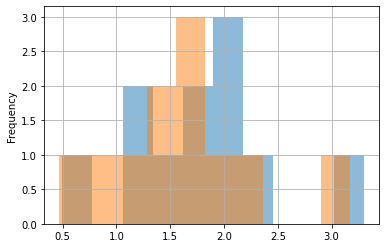

In [29]:
mut_types_table.DnDs.plot.hist(alpha=.5)
mut_types_table_nexts.DnDs.hist(alpha=.5)

In [22]:
rec = [rec for rec in SeqIO.parse(GENEBANK_PATH, "genbank")][0]
assert rec.seq == refseq

In [46]:
genes_aa_merged_seq = "".join([str(fea.translate(rec.seq)) for fea in rec.features if fea.type == 'gene'])

In [47]:
from collections import Counter

In [55]:
aa_counts = np.array(list(Counter(genes_aa_merged_seq).values()))
aa_counts = aa_counts / aa_counts.sum()
aa_counts

array([0.03126922, 0.04018864, 0.06868977, 0.12364158, 0.08027476,
       0.03424236, 0.04910806, 0.04572483, 0.05003076, 0.05556695,
       0.07227804, 0.02347755, 0.04008612, 0.03198688, 0.03834324,
       0.05546442, 0.02850113, 0.04121386, 0.06089809, 0.01035473,
       0.01865901])

In [58]:
np.sum(aa_counts ** 2) * 700_000

41954.39091375119

In [28]:
past_start, past_end = 0, 0

for fea in rec.features:
    if fea.type == "gene":
        cur_start = fea.location.start 
        cur_end = fea.location.end - 1
        gene_name = fea.qualifiers['gene'][0]
        print(f"{gene_name}\t {cur_start}\t {cur_end}")
        
        if cur_start <= past_end:
            print('-'*20)
            print(past_end, cur_start)
            print(fea)
            print('-'*20)
            
        past_start, past_end = cur_start, cur_end

ORF1ab	 265	 21554
S	 21562	 25383
ORF3a	 25392	 26219
E	 26244	 26471
M	 26522	 27190
ORF6	 27201	 27386
ORF7a	 27393	 27758
ORF7b	 27755	 27886
--------------------
27758 27755
type: gene
location: [27755:27887](+)
qualifiers:
    Key: db_xref, Value: ['GeneID:43740574']
    Key: gene, Value: ['ORF7b']
    Key: locus_tag, Value: ['GU280_gp08']

--------------------
ORF8	 27893	 28258
N	 28273	 29532
ORF10	 29557	 29673
